
 # Lab 1: Generative Adversarial Networks
In this lab, we will explore several architectures of generative adversarial networks. There are many different versions of GANs existing today. The break-up for today's lab is as follows:<ol>
1. Vanilla GAN
2. Conditional GAN
3. Cycle GAN

These codes are modified from https://github.com/wiseodd/generative-models/tree/master/GAN



## Module 1: Vanilla GAN

In [1]:
# Initialization of libraries
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms
device = torch.device('cuda')
%matplotlib inline

In [2]:
# defining parameters for the training
mb_size = 64 # Batch Size
Z_dim = 100  # Length of noise vector
X_dim = 784  # Input Length
h_dim = 128  # Hidden Dimension
lr = 1e-3    # Learning Rate

Custom weights initialization function.

(Read later about Xavier initialization: http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization)

(Link to paper: https://arxiv.org/abs/1406.2661)

In [3]:
# Custom weight initialization
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    vec = torch.randn(*size) * xavier_stddev

    vec = vec.to(device)
    vec.requires_grad = True
    return vec

We are using MNIST dataset for these experiments. Let us load the dataset. We will also define some functions that will be used for the other modules of this lab. Note that we are flattening the MNIST images into one dimensional vectors.

In [4]:
dataroot = './data'
# Applying transformation to images
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1,))])

# defining dataloader for the images
trainset = torchvision.datasets.MNIST(root=dataroot , train=True, download=False,transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size, shuffle=True, num_workers=2)

# function to get the next batch
def mnist_next(dataiter):

    try:
        images, labels = dataiter.next()
        images = images.view(images.numpy().shape[0],28*28)
    except:
        dataiter = iter(trainloader)
        images, labels = dataiter.next()
        images = images.view(images.numpy().shape[0],28*28)
    return images.numpy(), labels

# Initialization of dataloader
def initialize_loader(trainset):
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=mb_size, shuffle=True, num_workers=2)
    dataiter = iter(trainloader)
    return dataiter

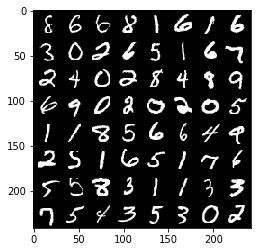

In [5]:
# print some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
img = torchvision.utils.make_grid(images)
npimg = img.numpy()
plt.imshow(np.transpose(npimg, (1, 2, 0)))

 Now, let us define the network structure. For this experiment, we are not using deep networks. We are not even using torch.nn layers. Instead, we will use simple linear fully connected layers. The generator and discriminators are 2-layer networks. This is why we flattened the images in the block above.

In [6]:
""" ==================== GENERATOR ======================== """
# generator weight initialization
Wzh = xavier_init(size=[Z_dim, h_dim])
Whx = xavier_init(size=[h_dim, X_dim])

# generator bias initialization
bzvar = torch.zeros(h_dim);
bhvar = torch.zeros(X_dim);

bzvar = bzvar.to(device)
bhvar = bhvar.to(device)
    
bzh = Variable(bzvar, requires_grad=True)
bhx = Variable(bhvar, requires_grad=True)

# trainable parameters of generator 
G_params = [Wzh, bzh, Whx, bhx]

In [7]:
# Network architecture of generator
def G(z):
    h = nn.relu(torch.mm(z, Wzh) + bzh.repeat(z.size(0), 1))
    X = nn.sigmoid(torch.mm(h, Whx) + bhx.repeat(h.size(0), 1))
    return X  

In [8]:
""" ==================== DISCRIMINATOR ======================== """
# Discriminator weight initialization
Wxh = xavier_init(size=[X_dim, h_dim])
Why = xavier_init(size=[h_dim, 1])

# Discriminator bias initialization
bxvar = torch.zeros(h_dim)
bhvar = torch.zeros(1)

bxvar = bxvar.to(device)
bhvar = bhvar.to(device)
    
bxh = Variable(bxvar, requires_grad=True)
bhy = Variable(bhvar, requires_grad=True)

# trainable parameters of discriminator 
D_params = [Wxh, bxh, Why, bhy]

In [9]:
# Network architecture of discriminator
def D(X):
    h = nn.relu(torch.mm(X, Wxh) + bxh.repeat(X.size(0), 1))
    y = nn.sigmoid(torch.mm(h, Why) + bhy.repeat(h.size(0), 1))
    return y  

Here, we will gather the parameters of the generator and the discriminator so that they can be given to the Adam optimizer to update the weights

In [10]:
G_solver = optim.Adam(G_params, lr)
D_solver = optim.Adam(D_params, lr)

ones_label = torch.ones(mb_size,1)
zeros_label = torch.zeros(mb_size,1)

ones_label = ones_label.to(device)
zeros_label = zeros_label.to(device)

In [11]:
# Reset the gradients to zero
params = G_params + D_params
def reset_grad():
    for p in params:
        p.grad.data.zero_()

 Now, we will start the actual training. The training alternates between updating the discriminator network's weights and updating the generator's weight.First, we update the discriminator's weight. We take a minibatch from the dataset and do a forward pass on the discriminator with the label '1'. Then, we feed noise into the generator and feed the generated images into the discriminator with the label '0'. We backpropagate the error and update the discriminator weights. To update the generator weights, we feed noise to the generator and feed the generated images into the discriminator with the label '1'. This error is backpropagated to update the weights of G.

In [12]:
dataiter = initialize_loader(trainset)

for it in range(10000):
    
    # Sample data
    z = torch.randn(mb_size, Z_dim)
    X, _ = mnist_next(dataiter)
    if X.shape[0]!=mb_size:
        dataiter = initialize_loader(trainset)
        X,_ = mnist_next(dataiter)
    X = torch.from_numpy(X)
    
    X = X.to(device)
    z = z.to(device)
    
    # Dicriminator forward-loss-backward-update
    
    #forward pass
    G_sample = G(z)
    D_real = D(X)
    D_fake = D(G_sample)
    
    # Calculate the loss
    D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
    D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
    D_loss = D_loss_real + D_loss_fake

    # Calulate and update gradients of discriminator
    D_loss.backward()
    D_solver.step()

    # reset gradient
    reset_grad()

    # Generator forward-loss-backward-update
    
    z = torch.randn(mb_size, Z_dim)
    z = z.to(device)
    G_sample = G(z)
    D_fake = D(G_sample)

    G_loss = nn.binary_cross_entropy(D_fake, ones_label)

    G_loss.backward()
    G_solver.step()

    # reset gradient
    reset_grad()

    # Print and plot every now and then
    if it % 1000 == 0:
        print('Iter-{}; D_loss: {}; G_loss: {}'.format(it, D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy()))

/home/avideep/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iter-0; D_loss: 1.462895154953003; G_loss: 2.28584361076355
Iter-1000; D_loss: 0.004510858096182346; G_loss: 8.650317192077637
Iter-2000; D_loss: 0.009105376899242401; G_loss: 9.357132911682129
Iter-3000; D_loss: 0.05595117807388306; G_loss: 5.487269401550293
Iter-4000; D_loss: 0.10895150899887085; G_loss: 6.225259780883789
Iter-5000; D_loss: 0.2919051945209503; G_loss: 4.809887886047363
Iter-6000; D_loss: 0.4120819568634033; G_loss: 3.972104549407959
Iter-7000; D_loss: 0.4178468585014343; G_loss: 5.106117248535156
Iter-8000; D_loss: 0.5076912641525269; G_loss: 3.0934743881225586
Iter-9000; D_loss: 0.7842972874641418; G_loss: 3.4072303771972656


 Let us see the images generated by the generator:

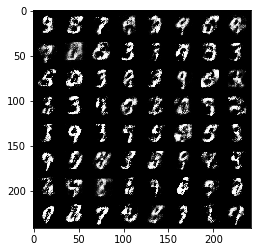

In [13]:
z = torch.randn(mb_size, Z_dim)
z = z.to(device)
samples = G(z)
samples = samples.cpu()
img = samples.data
img = img.view([64,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())

### Image interpolation

Let us try to interpolate between images

In [ ]:
# Generate 64 random noise vector by interpolating between two noise vector
a = torch.randn(Z_dim);
b = torch.randn(Z_dim);
noise = torch.Tensor(mb_size,Z_dim)
line  = torch.linspace(0, 1, mb_size)
for i in range(0, mb_size):
    noise.select(0, i).copy_(a * line[i] + b * (1 - line[i]))
noise = noise.to(device)

# Feed forward the interpolated noise vector to generator
samples = G(noise)
samples = samples.cpu()

# Plot the generated images
img = samples.data
img = img.view([mb_size,1,28,28])
img = torchvision.utils.make_grid(img)
img = img.permute(1,2,0)
plt.imshow(img.numpy())


## Points to ponder
1. What happens if we don't do Xavier initialization?
2. What happens if we change the learning rate and other parameters?
3. What happens if we reduce the size of hidden layer to 10?
4. Is there any way to determine the class of the generated images by changing the input noise vector?
5. How long do we have to train the GAN to get good results? Can you plot the loss of the generator and discriminator and see if there is a correlation?
